In [1]:
# HNSW Baseline Analysis - FAISS Baseline建立和Effort分析
from io_utils import read_fbin, read_ibin
import faiss
import numpy as np
import time
import json
import matplotlib.pyplot as plt
from collections import defaultdict

print(f"FAISS版本: {faiss.__version__}")

# 数据路径
file_path = "/root/code/vectordbindexing/Text2Image/base.1M.fbin"
query_path = "/root/code/vectordbindexing/Text2Image/query.public.100K.fbin"
ground_truth_path = "/root/code/vectordbindexing/Text2Image/groundtruth.public.100K.ibin"

# 读取数据集
print("\n=== 读取数据集 ===")
print("读取图像向量...")
data_vector = read_fbin(file_path)
print(f"图像向量: {data_vector.shape}, dtype: {data_vector.dtype}")

print("读取查询向量...")
query_vector = read_fbin(query_path)
print(f"查询向量: {query_vector.shape}, dtype: {query_vector.dtype}")

# 使用前500K数据进行测试（可以根据需要调整）
train_data_vector = data_vector[:500000]
print(f"使用训练数据: {train_data_vector.shape}")


FAISS版本: 1.11.0

=== 读取数据集 ===
读取图像向量...
图像向量: (1000000, 200), dtype: float32
读取查询向量...
查询向量: (100000, 200), dtype: float32
使用训练数据: (500000, 200)


In [4]:
# 1. 创建FAISS Baseline索引
print("\n=== 1. 创建FAISS Baseline索引 ===")

# 创建FAISS HNSW索引作为baseline
print("创建FAISS HNSW索引...")
dim = train_data_vector.shape[1]
faiss_index = faiss.IndexHNSWFlat(dim, 64)  # M=32
faiss_index.hnsw.efConstruction = 200  # ef_construction
faiss_index.hnsw.efSearch = 1000  # 使用较大的ef_search确保准确性

# 添加训练数据
print("添加训练数据到FAISS索引...")
start_time = time.time()
faiss_index.add(train_data_vector.astype('float32'))
build_time = time.time() - start_time
print(f"FAISS索引构建完成，耗时: {build_time:.2f}秒")
print(f"索引统计: 总向量数={faiss_index.ntotal}")



=== 1. 创建FAISS Baseline索引 ===
创建FAISS HNSW索引...
添加训练数据到FAISS索引...


FAISS索引构建完成，耗时: 6.90秒
索引统计: 总向量数=500000


In [7]:
# 2. FAISS搜索生成Ground Truth和Effort分析
print("\n=== 2. FAISS搜索生成Ground Truth ===")

test_query_count = len(query_vector)
test_queries = query_vector

print(f"测试查询数量: {test_query_count}")
print("开始FAISS搜索...")

# 存储结果
faiss_top100_results = {}
faiss_effort_stats = []
faiss_search_times = []

start_time = time.time()
for i, query in enumerate(test_queries):
    if i % 10000 == 0:
        print(f"  处理查询 {i+1}/{test_query_count}")
    
    # FAISS搜索
    query_start = time.time()
    query_reshaped = query.reshape(1, dim).astype('float32')
    distances, indices = faiss_index.search(query_reshaped, k=100)
    query_time = time.time() - query_start
    
    # 记录top100结果
    faiss_top100_results[i] = indices[0].tolist()
    
    # 记录搜索时间和effort（这里用搜索时间作为effort的代理）
    faiss_search_times.append(query_time)
    faiss_effort_stats.append(query_time)

total_time = time.time() - start_time
print(f"FAISS搜索完成，总耗时: {total_time:.2f}秒")
print(f"平均每个查询耗时: {np.mean(faiss_search_times)*1000:.2f}ms")



=== 2. FAISS搜索生成Ground Truth ===
测试查询数量: 100000
开始FAISS搜索...
  处理查询 1/100000


  处理查询 10001/100000
  处理查询 20001/100000
  处理查询 30001/100000
  处理查询 40001/100000
  处理查询 50001/100000
  处理查询 60001/100000
  处理查询 70001/100000
  处理查询 80001/100000
  处理查询 90001/100000
FAISS搜索完成，总耗时: 287.98秒
平均每个查询耗时: 2.87ms


In [8]:
# 3. Effort分位数分析
print("\n=== 3. Effort分位数分析 ===")

# 计算effort分位数
effort_percentiles = [10, 25, 50, 75, 90, 95, 99]
effort_query_ids = {}

effort_array = np.array(faiss_effort_stats)
print(f"Effort统计信息:")
print(f"  均值: {np.mean(effort_array)*1000:.2f}ms")
print(f"  标准差: {np.std(effort_array)*1000:.2f}ms")
print(f"  最小值: {np.min(effort_array)*1000:.2f}ms")
print(f"  最大值: {np.max(effort_array)*1000:.2f}ms")

print(f"\nEffort分位数:")
for p in effort_percentiles:
    percentile_value = np.percentile(effort_array, p)
    # 找到最接近该分位数的query id
    closest_idx = np.argmin(np.abs(effort_array - percentile_value))
    effort_query_ids[p] = {
        'query_id': int(closest_idx),
        'effort_value': float(percentile_value),
        'effort_ms': float(percentile_value * 1000)
    }
    print(f"  P{p}: query_id={closest_idx}, effort={percentile_value*1000:.2f}ms")



=== 3. Effort分位数分析 ===
Effort统计信息:
  均值: 2.87ms
  标准差: 0.82ms
  最小值: 1.09ms
  最大值: 141.66ms

Effort分位数:
  P10: query_id=4955, effort=2.02ms
  P25: query_id=5681, effort=2.37ms
  P50: query_id=2192, effort=2.80ms
  P75: query_id=5755, effort=3.32ms
  P90: query_id=1247, effort=3.80ms
  P95: query_id=3841, effort=4.05ms
  P99: query_id=62275, effort=4.49ms



=== 4. 可视化分析 ===


/tmp/ipykernel_2402027/3591979784.py:46: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2402027/3591979784.py:46: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2402027/3591979784.py:46: UserWarning: Glyph 25628 (\N{CJK UNIFIED IDEOGRAPH-641C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2402027/3591979784.py:46: UserWarning: Glyph 32034 (\N{CJK UNIFIED IDEOGRAPH-7D22}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2402027/3591979784.py:46: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2402027/3591979784.py:46: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2402027/3591979784.py:46: UserWarning: Glyph 32047 (\N{CJK UN

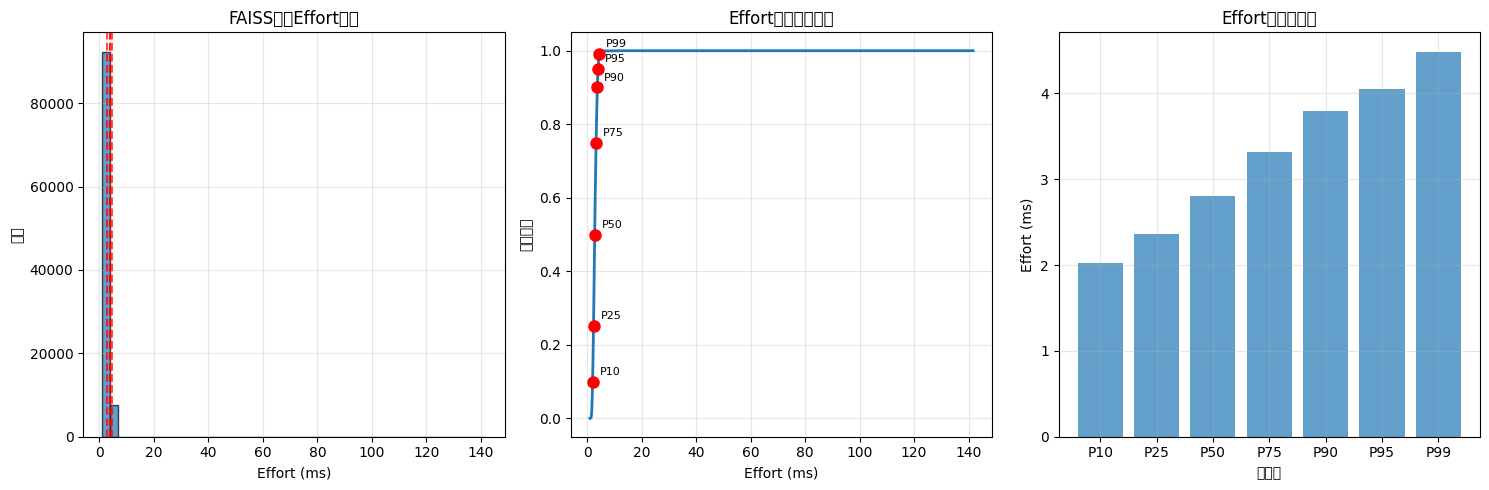


分位数统计表:
分位数      Query ID   Effort (ms)  相对比例      
---------------------------------------------
P10      4955       2.02         0.71      
P25      5681       2.37         0.82      
P50      2192       2.80         0.98      
P75      5755       3.32         1.16      
P90      1247       3.80         1.32      
P95      3841       4.05         1.41      
P99      62275      4.49         1.56      


In [9]:
# 4. 可视化分析
print("\n=== 4. 可视化分析 ===")

plt.figure(figsize=(15, 5))

# 子图1: Effort分布直方图
plt.subplot(1, 3, 1)
plt.hist(np.array(faiss_effort_stats)*1000, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Effort (ms)')
plt.ylabel('频次')
plt.title('FAISS搜索Effort分布')
plt.grid(True, alpha=0.3)

# 添加分位数线
for p in [50, 90, 95, 99]:
    percentile_value = np.percentile(effort_array, p)
    plt.axvline(percentile_value*1000, color='red', linestyle='--', alpha=0.7, label=f'P{p}')

# 子图2: 累积分布函数
plt.subplot(1, 3, 2)
sorted_efforts = np.sort(effort_array)
cumulative = np.arange(1, len(sorted_efforts) + 1) / len(sorted_efforts)
plt.plot(sorted_efforts*1000, cumulative, linewidth=2)
plt.xlabel('Effort (ms)')
plt.ylabel('累积概率')
plt.title('Effort累积分布函数')
plt.grid(True, alpha=0.3)

# 添加分位数点
for p in effort_percentiles:
    percentile_value = np.percentile(effort_array, p)
    plt.plot(percentile_value*1000, p/100, 'ro', markersize=8)
    plt.annotate(f'P{p}', (percentile_value*1000, p/100), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 子图3: 分位数对比
plt.subplot(1, 3, 3)
percentile_values = [np.percentile(effort_array, p) for p in effort_percentiles]
plt.bar(range(len(effort_percentiles)), np.array(percentile_values)*1000, alpha=0.7)
plt.xlabel('分位数')
plt.ylabel('Effort (ms)')
plt.title('Effort分位数对比')
plt.xticks(range(len(effort_percentiles)), [f'P{p}' for p in effort_percentiles])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 显示分位数统计
print(f"\n分位数统计表:")
print(f"{'分位数':<8} {'Query ID':<10} {'Effort (ms)':<12} {'相对比例':<10}")
print("-" * 45)
mean_effort = np.mean(effort_array)
for p in effort_percentiles:
    info = effort_query_ids[p]
    ratio = info['effort_value'] / mean_effort
    print(f"P{p:<7} {info['query_id']:<10} {info['effort_ms']:<12.2f} {ratio:<10.2f}")


In [10]:
# 5. 保存结果到文件
print("\n=== 5. 保存结果到文件 ===")

# 文件A: FAISS top100结果
file_a_path = '/root/code/vectordbindexing/faiss_top100_results.json'
with open(file_a_path, 'w') as f:
    json.dump(faiss_top100_results, f, indent=2)
print(f"文件A已保存: {file_a_path}")
print(f"  包含 {len(faiss_top100_results)} 个查询的top100结果")

# 文件B: Effort分位数对应的query id
file_b_path = '/root/code/vectordbindexing/faiss_effort_percentiles.json'
with open(file_b_path, 'w') as f:
    json.dump(effort_query_ids, f, indent=2)
print(f"文件B已保存: {file_b_path}")
print(f"  包含 {len(effort_query_ids)} 个分位数对应的query id")

# 额外保存: 完整的effort统计信息
effort_stats_complete = {
    'effort_stats': faiss_effort_stats,
    'search_times': faiss_search_times,
    'percentiles': effort_query_ids,
    'summary': {
        'total_queries': test_query_count,
        'mean_effort_ms': float(np.mean(effort_array) * 1000),
        'std_effort_ms': float(np.std(effort_array) * 1000),
        'min_effort_ms': float(np.min(effort_array) * 1000),
        'max_effort_ms': float(np.max(effort_array) * 1000)
    }
}

file_c_path = '/root/code/vectordbindexing/faiss_effort_stats.json'
with open(file_c_path, 'w') as f:
    json.dump(effort_stats_complete, f, indent=2)
print(f"文件C已保存: {file_c_path}")
print(f"  包含完整的effort统计信息")

# 总结报告
print(f"\n=== FAISS Baseline分析总结 ===")
print(f"1. 索引构建:")
print(f"   - 使用FAISS HNSW索引，M=32, ef_construction=200")
print(f"   - 训练数据: {train_data_vector.shape[0]} 个向量")
print(f"   - 构建时间: {build_time:.2f}秒")

print(f"\n2. 搜索测试:")
print(f"   - 测试查询: {test_query_count} 个")
print(f"   - 搜索宽度: ef_search=1000 (确保高准确性)")
print(f"   - 平均搜索时间: {np.mean(faiss_search_times)*1000:.2f}ms")

print(f"\n3. Effort分析:")
print(f"   - 定义了7个分位数: P10, P25, P50, P75, P90, P95, P99")
print(f"   - 每个分位数对应一个代表性的query ID")
print(f"   - 用于后续测试不同难度查询的搜索步长")

print(f"\n4. 输出文件:")
print(f"   - 文件A: faiss_top100_results.json (Ground Truth)")
print(f"   - 文件B: faiss_effort_percentiles.json (Effort分位数)")
print(f"   - 文件C: faiss_effort_stats.json (完整统计信息)")

print(f"\n5. 后续用途:")
print(f"   - 文件A将作为所有HNSW方法的ground truth")
print(f"   - 文件B将用于测试不同effort水平的查询")
print(f"   - 为三种HNSW方法对比提供baseline")

print(f"\n✅ FAISS Baseline分析完成！")



=== 5. 保存结果到文件 ===
文件A已保存: /root/code/vectordbindexing/faiss_top100_results.json
  包含 100000 个查询的top100结果
文件B已保存: /root/code/vectordbindexing/faiss_effort_percentiles.json
  包含 7 个分位数对应的query id
文件C已保存: /root/code/vectordbindexing/faiss_effort_stats.json
  包含完整的effort统计信息

=== FAISS Baseline分析总结 ===
1. 索引构建:
   - 使用FAISS HNSW索引，M=32, ef_construction=200
   - 训练数据: 500000 个向量
   - 构建时间: 6.90秒

2. 搜索测试:
   - 测试查询: 100000 个
   - 搜索宽度: ef_search=1000 (确保高准确性)
   - 平均搜索时间: 2.87ms

3. Effort分析:
   - 定义了7个分位数: P10, P25, P50, P75, P90, P95, P99
   - 每个分位数对应一个代表性的query ID
   - 用于后续测试不同难度查询的搜索步长

4. 输出文件:
   - 文件A: faiss_top100_results.json (Ground Truth)
   - 文件B: faiss_effort_percentiles.json (Effort分位数)
   - 文件C: faiss_effort_stats.json (完整统计信息)

5. 后续用途:
   - 文件A将作为所有HNSW方法的ground truth
   - 文件B将用于测试不同effort水平的查询
   - 为三种HNSW方法对比提供baseline

✅ FAISS Baseline分析完成！
